In [34]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from sklearn import tree
from sklearn.metrics import accuracy_score, recall_score, precision_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

In [35]:
df = pd.read_csv("retouren.csv")

**Data Cleaning**

In [36]:
df["user_dob"] = pd.to_datetime(df.user_dob)
df["user_reg_date"] = pd.to_datetime(df.user_reg_date)
df["order_date"] = pd.to_datetime(df.order_date)
df["delivery_date"] = pd.to_datetime(df.delivery_date)

df["age"] = df.order_date.dt.year - df.user_dob.dt.year -((df.order_date.dt.date)<(df.user_dob.dt.date))
df = df.drop(df[df.item_price == 999].index)
df = df.drop(df[df.delivery_date < df.order_date].index)

df.loc[df.item_color == "brwon","item_color"] = "brown"
df.loc[df.item_color == "blau","item_color"] = "blue"
df.loc[df.item_color == "dark oliv","item_color"] = "dark olive"

df = df.drop(df[df.item_color == "?"].index)

df["acc_age"] = df.order_date - df.user_reg_date 
df["acc_age"] = df.acc_age.dt.days

df_mark = df.groupby(["item_id","item_size","item_color"]).agg(maxprice=("item_price","max")).reset_index()
df = pd.merge(df,df_mark)
df["markdown"] = 0
df.loc[df.item_price < df.maxprice,"markdown"] = 1
df.drop(df[df.delivery_date.isna()].index, inplace=True)

**Testdaten**

In [37]:
df_grad = df.copy()

In [38]:
df_grad = df_grad[df_grad.age.isna() == False]

In [39]:
X = pd.get_dummies(df_grad[["item_id", "item_color",	"brand_id",	"item_price",	"user_id",	"user_title",	"user_state",	"age",	"acc_age",	"markdown"]])
y = df_grad["return"]

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

**Entscheidungsbaum**

Accuracy Train       0.56617, Accuracy Test        0.56467
Recall Train         0.84876, Recall Test          0.84829
Precision Train      0.54624, Precision Test       0.54461


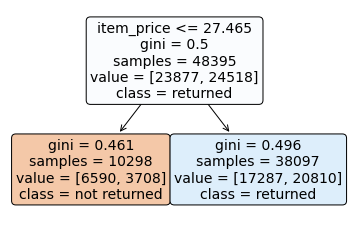

In [41]:
dtc = DecisionTreeClassifier(max_depth= 1, min_samples_split=2)
dtc.fit(X_train, y_train)

y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

print(f"{'Accuracy Train':17} {accuracy_score(y_train, y_pred_train):10.5f}, {'Accuracy Test':17} {accuracy_score(y_test, y_pred_test):10.5f}")
print(f"{'Recall Train':17} {recall_score(y_train, y_pred_train):10.5f}, {'Recall Test':17} {recall_score(y_test, y_pred_test):10.5f}")
print(f"{'Precision Train':17} {precision_score(y_train, y_pred_train):10.5f}, {'Precision Test':17} {precision_score(y_test, y_pred_test):10.5f}")

nodes = plot_tree(dtc, rounded=True, filled=True, fontsize=14, class_names=["not returned", "returned"], feature_names=X_train.columns)

**Baselinemodell mit Crossvalidation durch Kfold (Code aus dem Internet)**

In [51]:
crossvalidation = KFold(n_splits= 10, shuffle= True, random_state= 1)
for depth in range (1,10):
 tree_classifier = tree.DecisionTreeClassifier(max_depth = depth, random_state= 1)
 if tree_classifier.fit(X_train, y_train).tree_.max_depth < depth:
  break
 score = np.mean(cross_val_score(tree_classifier, X_train, y_train, scoring= "accuracy", cv= crossvalidation, n_jobs= 1))
 print(depth, score)

1 0.5659668985976544
2 0.5647685514902163
3 0.5719804054180992
4 0.5728480843490988
5 0.581485489796232
6 0.5830765269786292
7 0.5864239674545146
8 0.5871471463778289
9 0.5857625328981638


**Mit Code aus Ü8 und aus dem Internet**

In [48]:
min_samples = [2, 10, 20, 50, 100]
kf = KFold(n_splits= 10, shuffle= True, random_state= 1)
best_mean_score = 0
best_combination = dict(max_depth= None, min_samples= 2)

for depth in range(1,19):
 for min_sample in min_samples:
  scores = []
  classifier = DecisionTreeClassifier(max_depth= depth, min_samples_split= min_sample, random_state= 0)
  if classifier.fit(X_train, y_train).tree_.max_depth < depth:
   break
  score = np.mean(cross_val_score(classifier, X_train, y_train, scoring= "accuracy", cv= kf, n_jobs= 1))
  scores.append(score)

  mean_score = np.mean(np.array(scores))
 if mean_score > best_mean_score:
  best_combination["max_depth"] = depth
  best_combination["min_samples"] = min_sample
  best_mean_score = mean_score

In [52]:
best_mean_score, best_combination

(0.5865892182832667, {'max_depth': 8, 'min_samples': 100})

**Gradient Boosting Classifier**

In [ ]:
clf = GradientBoostingClassifier(n_estimators= 100, learning_rate= 1, max_depth= 8, random_state= 0)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)